In [22]:
%run srcnn.py
%run srPreprocessing.py
%matplotlib inline

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from keras.callbacks import ModelCheckpoint
print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6448178583889758695
]
[]


### Load images

In [3]:
PATH = "datasets"
TRAIN_FOLDER = PATH + "/DIV2K_train_HR/"

In [5]:
obj_files = load_images(TRAIN_FOLDER, 90)

### Generate train and test set
In the training phase, the ground truth images {Xi } are prepared as 32 × 32-
sub-images. To synthesize the low-resolution samples {Yi}, we blur a sub-image by a proper Gaussian kernel, sub-sample it by the upscaling factor, and upscale it by the same factor via bicubic interpolation. 
The sub-images are extracted from original images with a stride of 14.

#### Original image and bicubic interpolated image

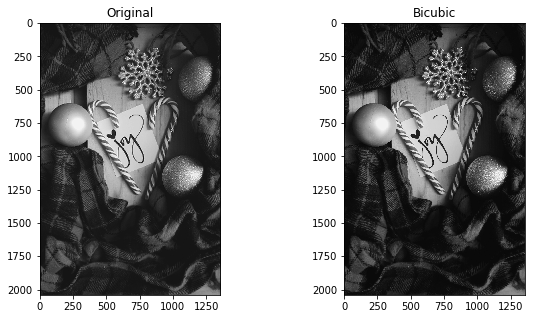

In [6]:
sample, label = get_input_images(obj_files[0],  scale = 4. )
plot_images([sample, label], ["Bicubic", "Original"], ch=1)

#### Example of our train and test set images

(32, 32)


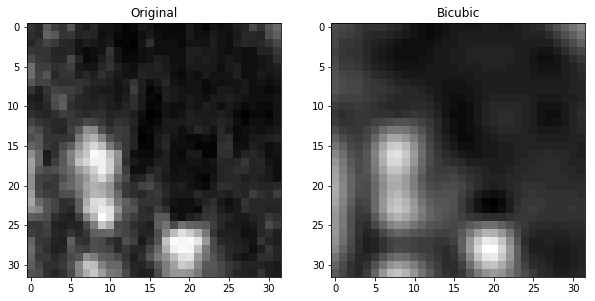

In [7]:
samples_list, labels_list = image_patches(obj_files,  scale = 4.)

print(labels_list[500].shape)
plot_images([samples_list[500], labels_list[500]], ["Bicubic", "Original"], ch=1)

In [8]:
samples = np.asarray(samples_list)
labels = np.asarray(labels_list)

samples = samples
labels = labels

In [9]:
train, test = normalize(samples, labels)
train, test = reshape(train, test, ch=1)

### Convolutional Neural Networks

In [24]:
model = srcnn_mode()
srcnn_compile(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 64)        36928     
__________

In [ ]:
batch_size = 64
epochs = 50


filepath="checkpoints/weights.spatial.best" +  "-{epoch:02d}-{val_loss:.4f}" + ".hdf5"


checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=5)
callbacks_list = [checkpoint]

model.fit(train, test,
          epochs=epochs,
          verbose=1,
          batch_size=batch_size,
          validation_split = 0.2,
          callbacks=callbacks_list)

In [11]:
## uncomment to save the model
name = "sptial_deep_model_50_ycbcr"
#save_model(model, name)

In [28]:
model = load_model(name)

In [13]:
TEST_FILE5 = "datasets/SR_Test/Set5/"
def get_test_dataset(test_name = TEST_FILE5) :
    vald_pil = load_images(TEST_FILE5)
    return vald_pil


(256, 256)


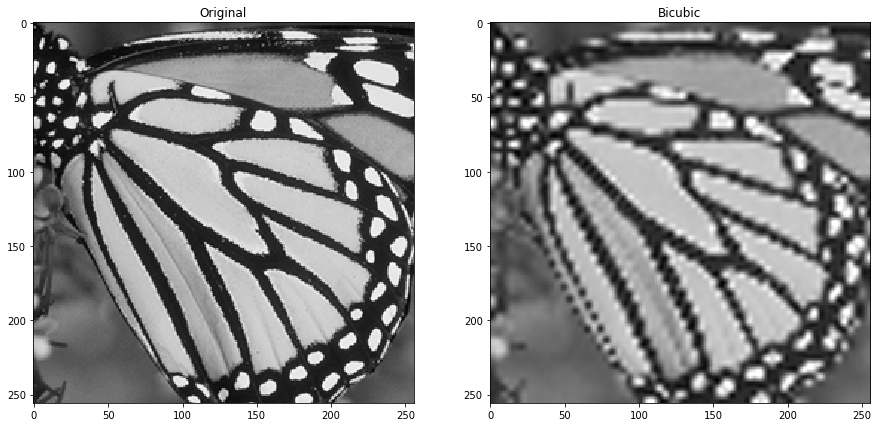

In [14]:
index=3
vald_pil = get_test_dataset()
val_img = vald_pil[index]

org, bicubic = get_input_images(val_img, 4.)

print(bicubic.shape)
plot_images([bicubic, org], ["Bicubic", "Original"], size=(15,10), ch=1)

In [15]:
val_img.shape

(256, 256)

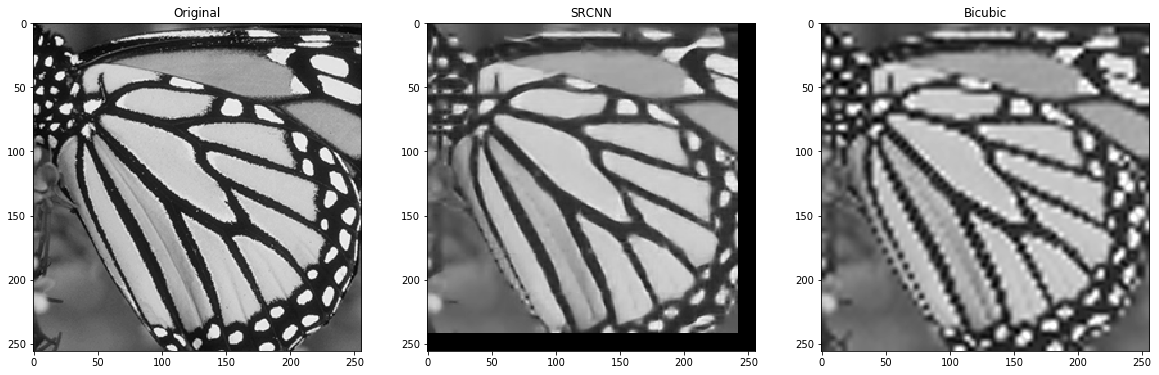

In [29]:
img = predict_image(model, val_img, patch_size = 32,scale = 4., stride = 30 )
plot_images([bicubic, val_img, img], ["Bicubic", "Original", "SRCNN"], size=(20, 10))


### test.shape

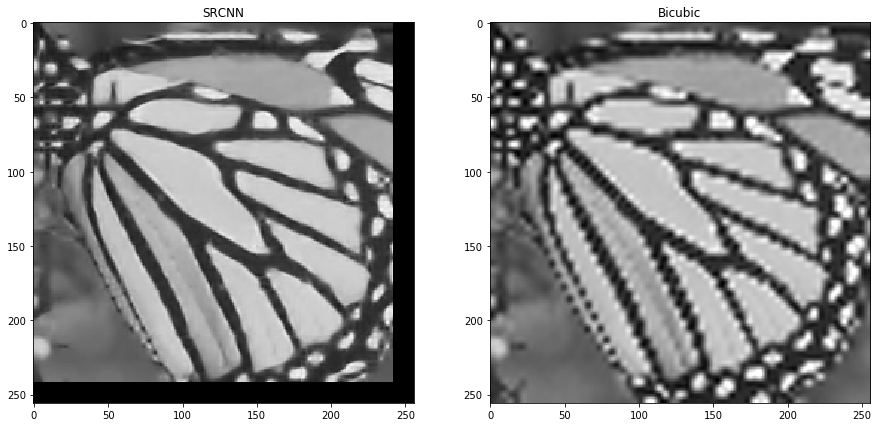

In [30]:
plot_images([bicubic, img], ["Bicubic", "SRCNN"], size=(15, 10))

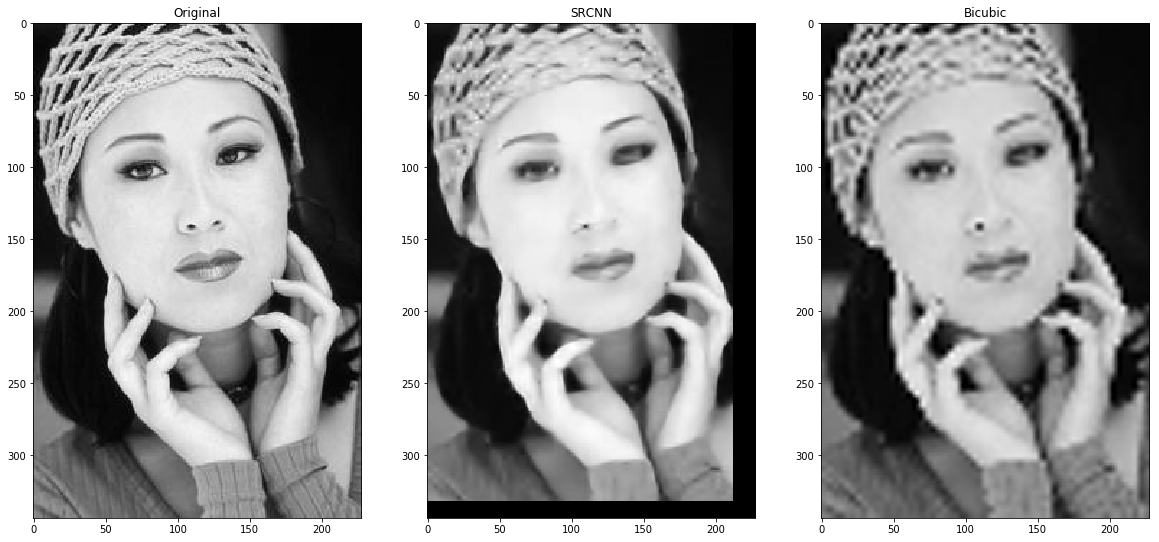

In [31]:
id = 0
val_img = vald_pil[id]

org, bicubic = get_input_images(val_img, 4.)

img = predict_image(model, val_img, patch_size = 32,scale = 4., stride = 30 )
plot_images([bicubic, val_img, img], ["Bicubic", "Original", "SRCNN"], size=(20, 10))

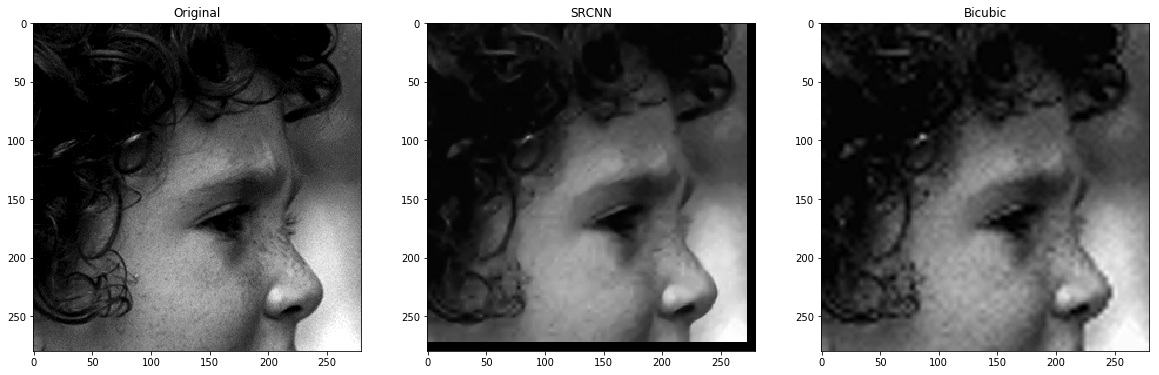

In [32]:
id = 2
val_img = vald_pil[id]

org, bicubic = get_input_images(val_img, 4.)

img = predict_image(model, val_img, patch_size = 32,scale = 4., stride = 30 )
plot_images([bicubic, val_img, img], ["Bicubic", "Original", "SRCNN"], size=(20, 10))

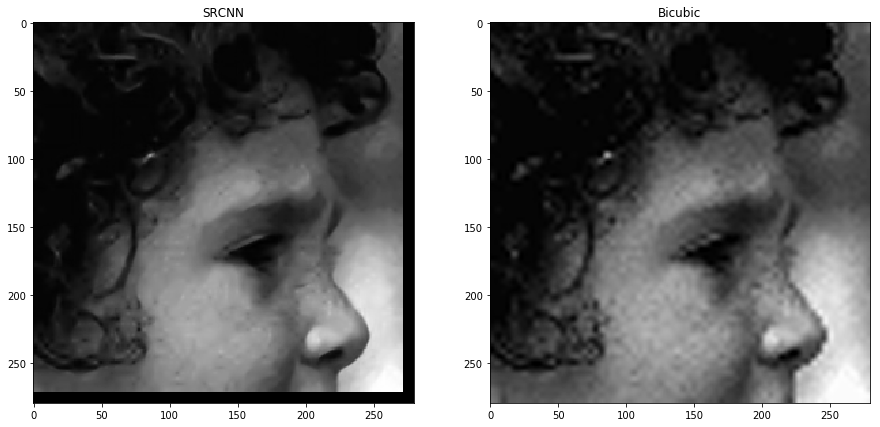

In [33]:
plot_images([bicubic, img], ["Bicubic", "SRCNN"], size=(15, 10))

# Load model

In [34]:
name = "sptial_deep_model_50_ycbcr"
model = load_model(name)

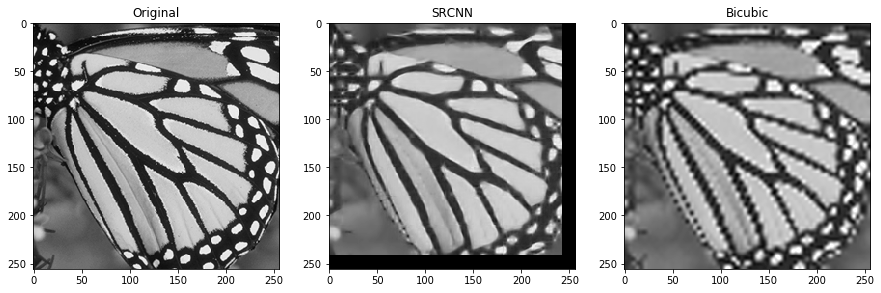

In [35]:
id = 3

vald_pil = get_test_dataset()
img = vald_pil[id]

org, bic = get_input_images(img, scale=4.)
image = predict_image(model, img, scale=4., stride=30)

plot_images([bic, org, image], ["Bicubic", "Original", "SRCNN"], size=(15, 15))